In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/preprocessed.csv')
df.head()

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100011,74,54482.111149,0.302678,1.050000,0.554054,41,0.418919,31,0.502230,...,30833.685,4.807692,32.0,26.0,1,1,435228.300,0.000,0.00,0.0
1,100013,96,18159.919219,0.115301,1.024890,0.770833,74,0.000000,0,0.865673,...,23147.820,5.722581,38.0,0.0,1,0,2072280.060,0.000,0.00,0.0
2,100023,8,0.000000,0.000000,0.000000,1.000000,8,0.000000,0,0.000000,...,0.000,15.653846,43.0,0.0,1,0,1645692.345,137038.500,0.00,0.0
3,100028,49,8085.058163,0.035934,0.165937,0.244898,12,0.142857,7,0.000000,...,8505.000,3.265487,19.0,0.0,1,0,1520875.080,186304.500,101390.76,0.0
4,100036,12,0.000000,0.000000,0.000000,1.000000,12,0.000000,0,0.000000,...,0.000,18.500000,67.0,0.0,0,3,94959.000,8339.355,0.00,0.0


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


categoricals = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
cols_to_scale = [
    'Avg_Monthly_Balance','Months_Fully_Paid', 
    'Months_Minimum_Paid', 'Months_Minimum_Paid', 
    'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
    'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
    'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
    'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
    'Tenure_Months'
]
others = df.columns.difference(categoricals + cols_to_scale)

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(), categoricals),
    ('scaled', MinMaxScaler(), cols_to_scale),
], remainder='passthrough')

In [6]:
X = df.drop(columns='W_DEFAULT')
y = df['W_DEFAULT']

X = preproc.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=1)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def auc_prc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc_score = make_scorer(auc_prc, needs_proba=True)

In [10]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

xgb = XGBClassifier()
rfecv_adasyn = RFECV(estimator=xgb, step=1, cv=10, scoring=make_scorer(matthews_corrcoef), n_jobs=4)
rfecv_adasyn.fit(X_adasyn, y_adasyn)

print(f'Optimal number of features: {rfecv_adasyn.n_features_}')

Optimal number of features: 65


In [11]:
X_adasyn_rfecv = rfecv_adasyn.transform(X_adasyn)
xgb.fit(X_adasyn_rfecv, y_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

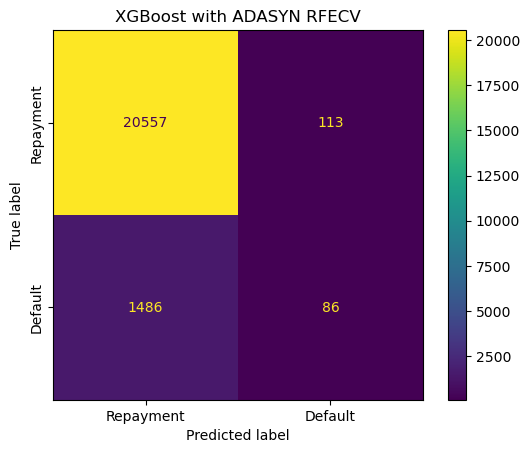

In [29]:
X_test_rfecv = rfecv_adasyn.transform(X_test)
y_pred = xgb.predict(X_test_rfecv)
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with ADASYN RFECV');

In [27]:
results = {}

y_pred = xgb.predict(X_test_rfecv)
y_proba = xgb.predict_proba(X_test_rfecv)

results['XGBoost + ADASYN'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost + ADASYN,0.432161,0.054707,0.09712,0.742814,0.276839,0.134016


In [36]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

seed = None
ros = RandomOverSampler(random_state=seed)
rus = RandomUnderSampler(random_state=seed)
smote = SMOTE(random_state=seed)
adasyn = ADASYN(random_state=seed)
tomek = TomekLinks()
smotetomek = SMOTETomek(random_state=seed)

methods = {
    # 'Original': 'passthrough',
    'Random Oversampling': ros,
    'Random Undersampling': rus,
    'SMOTE': smote,
    'ADASYN': adasyn,
    'Tomek': tomek,
    'SMOTETomek': smotetomek,
}

In [33]:
scoring = {
    'auc_prc': auc_prc_score, 
    'precision': make_scorer(precision_score), 
    'recall': make_scorer(recall_score),
    'mcc': make_scorer(matthews_corrcoef),
    'auc_roc': make_scorer(roc_auc_score)
}

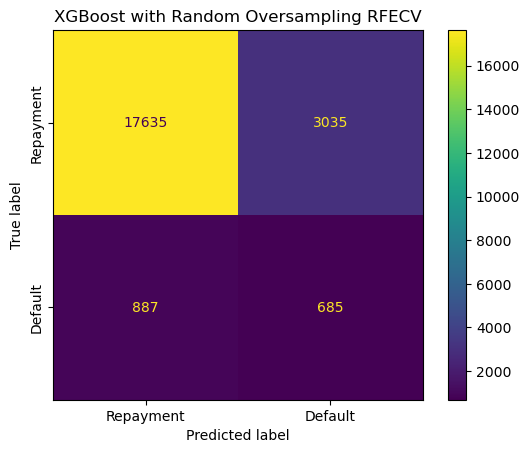

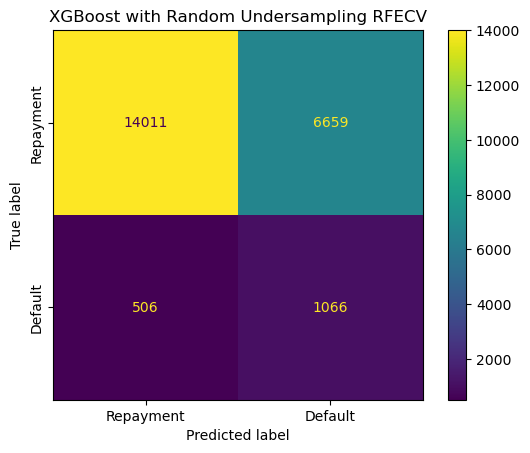

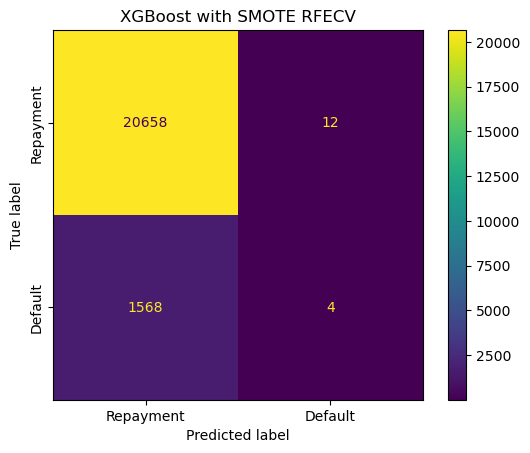

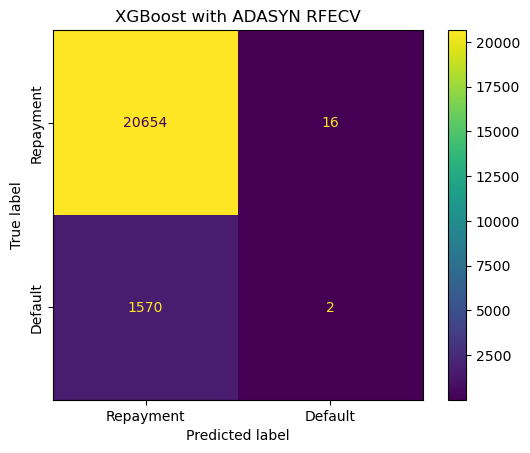

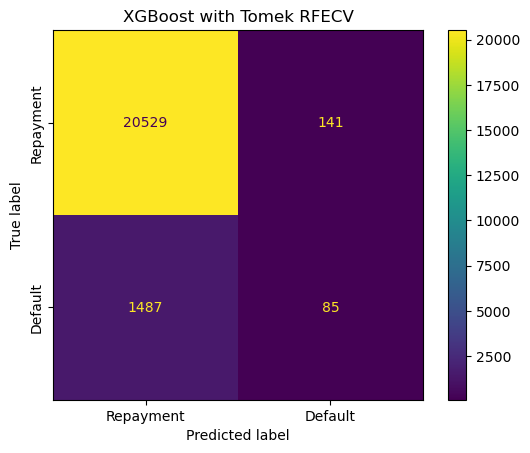

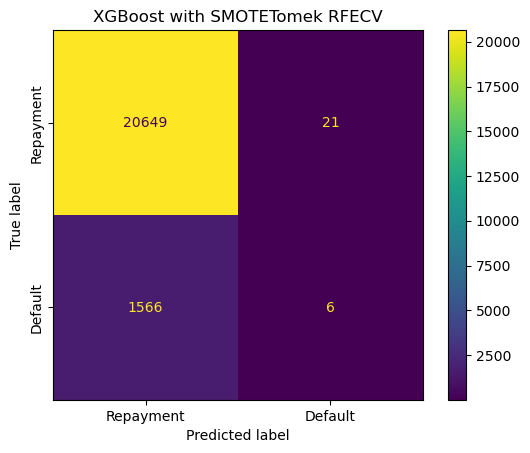

Results for XGBoost


""


In [ ]:
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline

all_results = []
models = {'XGBoost': XGBClassifier()}

rfecv_dict = {}

for model_name, model in models.items():
    results_model = {}

    for method, resampler in methods.items():

        X_samp, y_samp = resampler.fit_resample(X_train, y_train)
        rfecv = RFECV(estimator=model, step=1, cv=10, scoring=make_scorer(matthews_corrcoef), n_jobs=4)
        rfecv_dict[method] = rfecv

        rfecv.fit(X_samp, y_samp)

        X_samp_reduced = rfecv.transform(X_samp)
        model.fit(X_samp_reduced, y_samp)

        X_test_reduced = rfecv.transform(X_test)
        y_pred = model.predict(X_test_reduced)
        y_proba = model.predict_proba(X_test_reduced)
        cm = confusion_matrix(y_test, y_pred)

        from sklearn.metrics import ConfusionMatrixDisplay
        cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
        cm_display.plot()
        plt.yticks(rotation=90, va='center')
        plt.gca().set_title(f'{model_name} with {method} RFECV')
        plt.show()

        results_model[method] = {
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
            'PRC AUC': auc_prc(y_test, y_pred),
            'MCC': matthews_corrcoef(y_test, y_pred)
        }

        # We porbbaly should figure out how to use RFECV with the pipeline and test this way
        # pipeline = Pipeline(
        #     [
        #         (method, resampler),
        #         [model_name, model]
        #     ]
        # )

        # scores = cross_validate(pipeline, X, y, scoring=scoring)
        # scores = {key: np.mean(values) for key, values in scores.items()}

        # results_model[method] = {
        #     'Precision': scores['test_precision'],
        #     'Recall': scores['test_recall'],
        #     'AUC PRC': scores['test_auc_prc'],
        #     'AUC ROC': scores['test_auc_roc'],
        #     'MCC': scores['test_mcc'],
        #     'Training Time': scores['fit_time']
        # }
    
    results_model = pd.DataFrame.from_dict(results_model, orient='index')
    print(f'Results for {model_name}')
    display(results_model)

    results_model['Model'] = model_name
    all_results.append(results_model.reset_index(names='Sampler'))

all_results = pd.concat(all_results, axis=0).reset_index(drop=True)

In [39]:
results_model

,Model
